Empirical Discrepancy is defined as

$$ \widehat{\text{disc}_H}(q) = \sup\limits_{h\in H, h\in H_A} \left| \sum\limits^T_{t=1} q_t(L(h_t(X_{T+1}),h(X_{T+1})) - L(h_t,Z_t))\right|$$


How do we minimize the following?

$$ \widehat{\text{disc}_H}(q) + \sum\limits_{t=1}^T q_t L(h_t,Z_t)$$

First we need to modify an Online Expert

In [881]:
from expert_prediction.online_experts import *

ModuleNotFoundError: No module named 'expert_prediction'

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from scipy.optimize import minimize
from projective_gradient_descent import gd

# Creating Data

In [71]:
actual_values = np.random.randint(0,10,size=[40])
def create_expert(std,actual_values):
    return actual_values+np.random.randn(actual_values.size)*std
# Fixed Standard Deviations for each expert
stds = [1,0.1,0.03,0.5,1.3,2,5,1,2,1]
expert_predictions = np.array([create_expert(std,actual_values) for std in stds])

# Predictions from an Online Learner

In [72]:
test1 = OnlineHedgeDoubling(n=10,T=50,loss_func=se)

In [73]:
online_predictions = []

for i in range(40):
    online_predictions.append(test1._predict(expert_predictions[:,i]))
    test1._update(expert_predictions[:,i,np.newaxis],actual_values[i,np.newaxis])

In [74]:
online_predictions = np.array(online_predictions).T

In [75]:
predictions = (online_predictions*expert_predictions).sum(axis=0)

In [76]:
losses_t = se(predictions,actual_values)

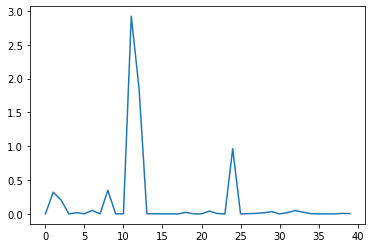

In [77]:
plt.plot(losses_t)

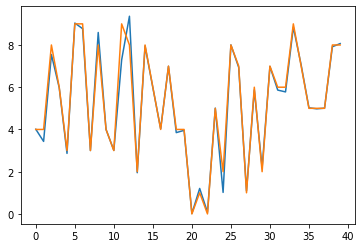

In [78]:
plt.plot(predictions)
plt.plot(actual_values)
# plt.plot(expert_predictions[6,:])

In [79]:
set_of_losses = np.array([se(np.dot(expert_predictions[:,39],online_predictions[:,:39]),h) for h in expert_predictions[:,39]])

In [80]:
def time_dependent_loss(hypotheses_seq, expert_predictions, actual_values,loss_func=None):
    predictions = (hypotheses_seq * expert_predictions).sum(axis=0)
    losses_t = loss_func(predictions,actual_values)
    
    return losses_t

# If we are considering choosing hypotheses individually
def discrepancy_simple(q, hypotheses_seq, expert_predictions, actual_values, updated_expert_predictions, loss_func=None):
    tdl = time_dependent_loss(hypotheses_seq, expert_predictions, actual_values,loss_func=se)
    
    set_of_hypothesis_losses = np.array([loss_func(np.dot(updated_expert_predictions,hypotheses_seq),h) for h in updated_expert_predictions])
    abs_total_losses = abs(np.dot(set_of_hypothesis_losses,q)-np.dot(tdl,q))
    sup_abs_total_losses = np.max(abs_total_losses)
    
    return sup_abs_total_losses


def discrepancy_optimize(q, hypotheses_seq, expert_predictions, actual_values, updated_expert_predictions, loss_func=None):
    tdl = time_dependent_loss(hypotheses_seq, expert_predictions, actual_values,loss_func=se)
    
    n = hypotheses_seq.shape[0]
    q_prime = np.ones(n)/n
    
    def inner_obj_func(x):
        set_of_hypothesis_losses = loss_func(np.dot(updated_expert_predictions,hypotheses_seq),np.dot(updated_expert_predictions,x))
        abs_total_losses = abs(np.dot(set_of_hypothesis_losses,q)-np.dot(tdl,q))
        return -abs_total_losses
        
    q_final = gd.projective_simplex_gradient_descent_2(q_prime,inner_obj_func,iterations=20,eta=0.2,epsilon=0.1)
    output = -inner_obj_func(q_final)
    
    return output

def discrepancy_two_stage_q(q, expert_predictions, actual_values, loss_func=None):
    n = len(q)
    uniform = np.ones(n)/n
    
    n_prime = expert_predictions.shape[0]
    w = np.ones(n_prime)/n_prime
    
#     def inner_obj_func(w):
#         predictions = np.dot(w,expert_predictions)
#         losses_t = loss_func(predictions,actual_values)
#         abs_total_losses = np.dot(uniform-q,losses_t)
#         return -abs_total_losses
        
    w_final = gd.projective_simplex_gradient_descent_2(w,inner_obj_func,iterations=100,eta=0.1)
    output = -inner_obj_func(w_final)
    
    return output

In [81]:
discrepancy_simple(np.ones(40)/40,online_predictions,expert_predictions,actual_values,expert_predictions[:,39],loss_func=se)

3.253484252449751

In [82]:
expert_predictions[9,39]

8.113632375779533

In [83]:
actual_values[39]

8

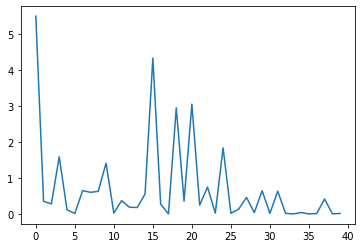

In [84]:
plt.plot(se(expert_predictions[9,:],actual_values))

# Optimizing Hyperparameters for Solving the Internal Problem in D_O

In [85]:
discrepancy_optimize(np.ones(40)/40,online_predictions,expert_predictions,actual_values,expert_predictions[:,39],loss_func=se)

0.10515209075871462

In [86]:
# Looking over the convex hull of the hypothesis won't help either
values = [discrepancy_optimize(np.ones(40)/40,online_predictions,expert_predictions,actual_values,expert_predictions[:,39],loss_func=se) for i in range(50)]

(array([3., 4., 2., 7., 5., 8., 6., 8., 3., 4.]),
 array([0.09228841, 0.09450721, 0.09672601, 0.09894482, 0.10116362,
        0.10338242, 0.10560122, 0.10782003, 0.11003883, 0.11225763,
        0.11447643]),
 <a list of 10 Patch objects>)

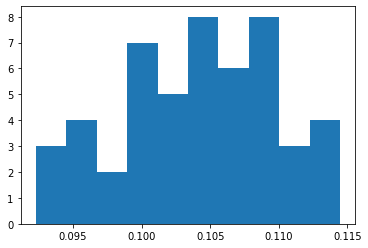

In [87]:
plt.hist(values)

The optimize function has a harder time for finding the maximium value for discrepancy

# Optimizing D_2

In [88]:
obj_func_c = lambda q: discrepancy_two_stage_q(q, expert_predictions, actual_values,loss_func=se)

In [89]:
%timeit obj_func_a(np.ones(39)/39)

KeyboardInterrupt: 

# Will take a 100x as long

In [194]:
%timeit obj_func_b(np.ones(39)/39)

11.1 ms ± 9.46 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [182]:
%timeit obj_func_c(np.ones(39)/39)

48.6 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Can it sense a regime change?

# Assembling the Objective Function

In [858]:
def objective_function_a(q, hypotheses_seq, expert_predictions,actual_values,loss_func=se):
    obj_hypotheses_seq = hypotheses_seq[:,:-1]
    obj_expert_predictions = expert_predictions[:,:-1]
    obj_actual_values = actual_values[:-1]
    
    update_expert_predictions = expert_predictions[:,-1]
    
    tdl = time_dependent_loss(obj_hypotheses_seq, obj_expert_predictions, obj_actual_values,loss_func=se)
    weighted_q_losses=np.dot(tdl,q)
    
    discrepancy_term = discrepancy_simple(q, obj_hypotheses_seq, obj_expert_predictions, obj_actual_values, update_expert_predictions, loss_func = loss_func)
    
    if np.isnan(discrepancy_term):
        raise ValueError("discrepancy went to nan")
    
    return discrepancy_term + weighted_q_losses

# Attempt controlling the loss as the occurs

In [744]:
def objective_function_b(q, hypotheses_seq, expert_predictions,actual_values,loss_func=se):
    obj_hypotheses_seq = hypotheses_seq[:,:-1]
    obj_expert_predictions = expert_predictions[:,:-1]
    obj_actual_values = actual_values[:-1]
    
    update_expert_predictions = expert_predictions[:,-1]
    
    tdl = time_dependent_loss(obj_hypotheses_seq, obj_expert_predictions, obj_actual_values,loss_func=se)
    weighted_q_losses=np.dot(tdl,q)
    
#     discrepancy_term = discrepancy_optimize(q, obj_hypotheses_seq, obj_expert_predictions, obj_actual_values, update_expert_predictions, loss_func = loss_func)
    
#     if np.isnan(discrepancy_term):
#         raise ValueError("discrepancy went to nan")
    
    return weighted_q_losses

In [92]:
q = np.ones(39)/39

In [93]:
objective_function_a(q,online_predictions,expert_predictions,actual_values,loss_func=se)

3.4242356175447255

# Testing out Minimization Approach

# First Objective Function

In [819]:
obj_func_a = lambda q: objective_function_a(q,online_predictions,expert_predictions,actual_values,loss_func=se)

In [823]:
online_predictions.shape

(10, 40)

In [824]:
expert_predictions.shape

(10, 40)

In [825]:
actual_values.shape

(40,)

What are the best algorithms for packing a simplex for a epsilon cover?

It could be started by trusting each one with the most and applying the following optimization algorithm:

In [855]:
samples1 = []
for i in range(15):
    sample = np.random.random(39)
    sample/=np.sum(sample)
    samples1.append(sample)

In [856]:
samples[0].shape

(39,)

In [370]:
importlib.reload(gd)

<module 'Projective_Gradient_Descent.gd' from '/home/memo/4995/Projective_Gradient_Descent/gd.py'>

In [861]:
uniform.shape

(39,)

In [860]:
check_a = np.array([gd.projective_simplex_gradient_descent_2(uniform,obj_func_a,iterations=100,eta=0.1,epsilon=0.01) for sample in samples1])

In [862]:
np.argmax([obj_func_a(check_a[i]) for i in range(15)])

14

In [863]:
[obj_func_a(check_a[i]) for i in range(15)]

[3.346458848391398,
 3.328899088741645,
 3.3769563592360115,
 3.35457588866399,
 3.363964322661782,
 3.345623113282355,
 3.334328660669983,
 3.346905737754046,
 3.376777026298983,
 3.3763759229498183,
 3.3753704126518924,
 3.3478507697031104,
 3.3261838866241957,
 3.3952137300874305,
 3.412528847961348]

In [864]:
optimal = np.zeros(39)

In [865]:
optimal[35:]=np.ones(4)/4

In [866]:
obj_func_a(optimal)

3.4146347269923307

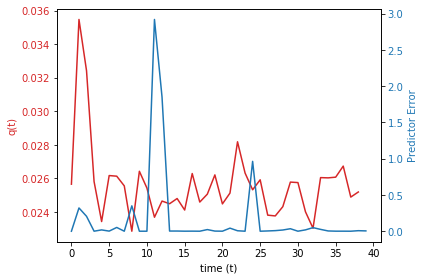

In [867]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (t)')
ax1.set_ylabel('q(t)', color=color)
ax1.plot(check_a.mean(axis=0), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predictor Error', color=color)  # we already handled the x-label with ax1
ax2.plot(se((online_predictions*expert_predictions).sum(axis=0),actual_values), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [868]:
check_a.mean(axis=0)[20:].sum()

0.48077006184635696

In [869]:
[obj_func_a(samples[i]) for i in range(15)]

[3.377854760977545,
 3.383670393862337,
 3.512025690835693,
 3.370336350066361,
 3.4338599250855686,
 3.4334005454508674,
 3.5174841909606114,
 3.3666441090573587,
 3.304450150877776,
 3.4474327112415244,
 3.575979194172877,
 3.536028922608241,
 3.3560077273701654,
 3.3257957197435744,
 3.555759771433697]

In [870]:
optimal = np.zeros(39)

In [871]:
optimal[1]=1

In [872]:
obj_func_a(optimal)

7.360572275524068

In [873]:
h = np.dot(online_predictions[:,:39],check_a.T)

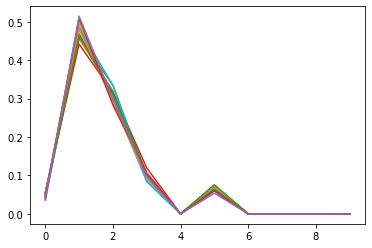

In [874]:
plt.plot(h)

In [875]:
h = np.dot(online_predictions[:,:39],check_a.T)

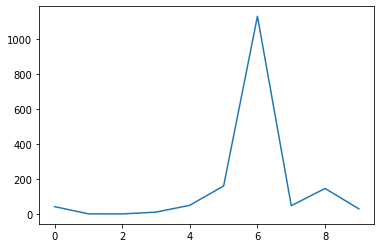

In [876]:
plt.plot(se(expert_predictions,actual_values).sum(axis=1))

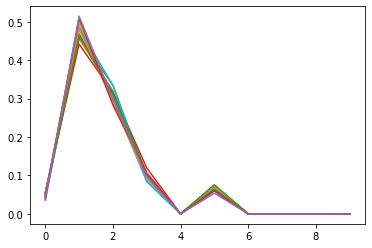

In [877]:
plt.plot(h,label="Discrepancy")

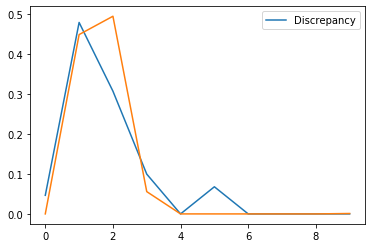

In [878]:
# stds_np = np.array(stds)
# inv_prob = 1/stds_np
# inv_prob/=np.sum(inv_prob)
plt.plot(h.mean(axis=1),label="Discrepancy")
# plt.plot(inv_prob)
plt.plot(test1.weights)
plt.legend()

In [479]:
np.dot(online_predictions[:,39],expert_predictions[:,39])

8.066045655495953

Overall not too impressed by the performance of the algorithm

## Subgradient Descent

In [813]:
def projected_subgradient_descent(start,obj_func,iterations=100,epsilon=0.02,noise_factor=0.0):
    history = []
    min_value = obj_func(start)
    values = []
    x = start
    n = len(x)
    
    a=epsilon*np.diag(np.ones(n)) + noise_factor*np.random.randn(n,n)
    perturbations = np.concatenate((a,-a),axis=0)
    
    for i in range(iterations):
        total_xs = np.outer(x,np.ones(2*n)).T
        dM = total_xs+perturbations
        dF = min_value-np.apply_along_axis(obj_func,1,dM)
        
        i=np.argmax(dF)
#         i = np.random.choice(np.arange(2*n)[dF>0])
        x += perturbations[i]
        x = gd.project_to_simplex_2(x)
        history.append(x)
        values.append(obj_func(x))
        x = history[np.argmin(values)]
        min_value = obj_func(x)
        print(min_value)
            
    return (x,values,history)

In [814]:
x,values,history = projected_subgradient_descent(np.ones(39)/39,obj_func_a,iterations=200,epsilon=0.1)

3.422117589093787
3.4220632806719653
3.422061888148331
3.4220618524425968
3.4220618515270673
3.42206185150359
3.4220618515029857
3.4220618515029733
2.997035180161848
3.41994382305203
2.9949171517109052
3.4198895146302126
2.994862843289088
3.419888122106575
2.99486145076545
3.4198880864008445
2.9948614150597193
3.41988808548531
2.994861414144185
3.419888085461834
2.9948614141207086
3.4198880854612335
2.994861414120108
3.419888085461217
2.994861414120092
3.419888085461216
2.9948614141200913
2.5698347427789665
3.4177700570102774
2.9927433856691525
2.5677167143280277
3.4177157485884604
2.992689077247335
2.5676624059062103
3.4177143560648227
2.9926876847236974
2.5676610133825726
3.417714320359088
2.9926876490179626
2.5676609776768373
3.4177143194435575
2.9926876481024323
2.5676609767613074
3.4177143194200816
2.9926876480789564
2.567660976737831
3.4177143194194812
2.992687648078356
2.5676609767372307
3.417714319419465
2.9926876480783395
2.5676609767372147
3.4177143194194644
2.992687648078339

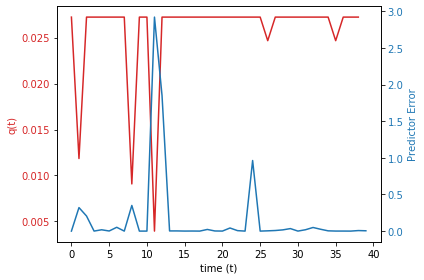

In [815]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (t)')
ax1.set_ylabel('q(t)', color=color)
ax1.plot(history[-1], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predictor Error', color=color)  # we already handled the x-label with ax1
ax2.plot(se((online_predictions*expert_predictions).sum(axis=0),actual_values), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Second Objective Function

In [755]:
uniform = np.ones(39)/39

In [756]:
obj_func_b = lambda q: objective_function_b(q,online_predictions,expert_predictions,actual_values,loss_func=se)

In [757]:
check_b = np.array([gd.projective_simplex_gradient_descent_2(sample,obj_func_b,iterations=200,eta=0.2,epsilon=0.01) for sample in samples])

In [758]:
[obj_func_b(value) for value in check_b]

[0.12063762455199353,
 0.12056428375137462,
 0.10201469908756716,
 0.10955142399956616,
 0.11677495147439412,
 0.10901770727392526,
 0.10992866848857816,
 0.10346700622726702,
 0.1279912425924551,
 0.11655737973339998,
 0.11883833694950922,
 0.1159300371267169,
 0.11230838463991585,
 0.12494799669061893,
 0.12562700380592232]

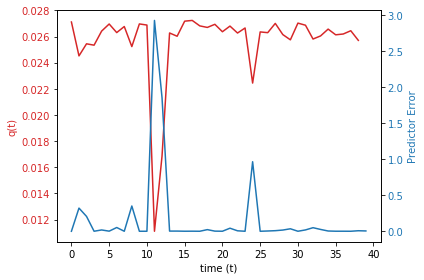

In [759]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (t)')
ax1.set_ylabel('q(t)', color=color)
ax1.plot(check_b.mean(axis=0), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predictor Error', color=color)  # we already handled the x-label with ax1
ax2.plot(se((online_predictions*expert_predictions).sum(axis=0),actual_values), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Regime Changes

In [769]:
new_actual_values = np.random.randint(0,10,size=[40])
def create_expert(std,actual_values):
    return actual_values+np.random.randn(actual_values.size)*std
# Fixed Standard Deviations for each expert
stds = [0,0,0,0,0,0,0,0,0,0]
new_expert_predictions = np.array([create_expert(std,new_actual_values) for std in stds])

In [770]:
regime_change = np.concatenate((expert_predictions,new_expert_predictions),axis=1)

In [771]:
regime_new_actual_values = np.concatenate((actual_values,new_actual_values))

In [772]:
test2 = OnlineHedgeDoubling(n=10,T=100,loss_func=se)

In [773]:
new_online_predictions = []

for i in range(80):
    new_online_predictions.append(test2._predict(regime_change[:,i]))
    test2._update(regime_change[:,i,np.newaxis],regime_new_actual_values[i,np.newaxis])

In [774]:
new_online_predictions = np.array(new_online_predictions).T

In [775]:
# If we are considering choosing hypotheses individually
def discrepancy_nan(q, hypotheses_seq, expert_predictions, actual_values, updated_expert_predictions, loss_func=None):
    tdl = time_dependent_loss(hypotheses_seq, expert_predictions, actual_values,loss_func=se)
    
    set_of_hypothesis_losses = np.array([loss_func(np.dot(updated_expert_predictions,hypotheses_seq),h) for h in updated_expert_predictions])
#     abs_total_losses = abs(np.dot(set_of_hypothesis_losses,q)-np.dot(tdl,q))
#     sup_abs_total_losses = np.max(abs_total_losses)
    
    return set_of_hypothesis_losses, tdl

def objective_function_c(q, hypotheses_seq, expert_predictions,actual_values,loss_func=se):
    obj_hypotheses_seq = hypotheses_seq[:,:-1]
    obj_expert_predictions = expert_predictions[:,:-1]
    obj_actual_values = actual_values[:-1]
    
    update_expert_predictions = expert_predictions[:,-1]
    
    tdl = time_dependent_loss(obj_hypotheses_seq, obj_expert_predictions, obj_actual_values,loss_func=se)
    weighted_q_losses=np.dot(tdl,q)
    
    discrepancy_term = discrepancy_nan(q, obj_hypotheses_seq, obj_expert_predictions, obj_actual_values, update_expert_predictions, loss_func = loss_func)
    
#     if np.isnan(discrepancy_term):
#         raise ValueError("discrepancy went to nan")
    
    return discrepancy_term

In [776]:
obj_func_c = lambda q: objective_function_c(q,new_online_predictions,regime_change,regime_new_actual_values,loss_func=se)

In [777]:
np.dot(regime_change[:,79],new_online_predictions)

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.])

In [778]:
set_of_hypothesis_losses, tdl = obj_func_c(1)

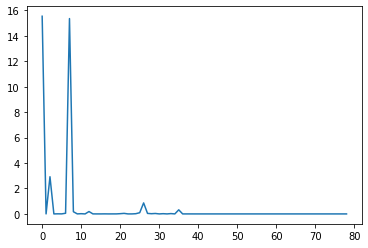

In [780]:
plt.plot(tdl)

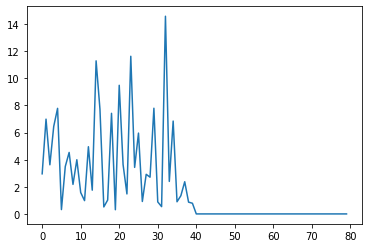

In [781]:
plt.plot(se(regime_change,regime_new_actual_values).mean(axis=0))

In [782]:
obj_func_a = lambda q: objective_function_a(q,new_online_predictions,regime_change,regime_new_actual_values,loss_func=se)

In [783]:
samples = []
for i in range(15):
    sample = np.random.random(79)
    sample/=np.sum(sample)
    samples.append(sample)

In [784]:
[obj_func_a(sample) for sample in samples]

[0.3746118671699118,
 0.5525528076519902,
 1.586561018780658,
 1.444562600680774,
 1.2890564677620864,
 0.5333045475505648,
 0.4909897636405663,
 1.137009708695114,
 0.8470747394815041,
 0.37588464032511615,
 0.9981424917881432,
 0.7704560175209569,
 0.9088859860891829,
 1.3408739936042506,
 0.4655869598499447]

In [791]:
optimal = np.zeros(79)

In [792]:
optimal[40:] = np.ones(39)/39

In [788]:
check_rc = np.array([gd.projective_simplex_gradient_descent_2(np.ones(79)/79,obj_func_a,iterations=200,eta=10,epsilon=0.01,noise=0) for i in range(15)])

In [793]:
check_rc

array([[0.        , 0.01505407, 0.        , ..., 0.01533264, 0.01533264,
        0.01533264],
       [0.        , 0.01505407, 0.        , ..., 0.01533264, 0.01533264,
        0.01533264],
       [0.        , 0.01505407, 0.        , ..., 0.01533264, 0.01533264,
        0.01533264],
       ...,
       [0.        , 0.01505407, 0.        , ..., 0.01533264, 0.01533264,
        0.01533264],
       [0.        , 0.01505407, 0.        , ..., 0.01533264, 0.01533264,
        0.01533264],
       [0.        , 0.01505407, 0.        , ..., 0.01533264, 0.01533264,
        0.01533264]])

In [794]:
np.argmin([obj_func_a(check_rc[i]) for i in range(15)])

0

In [795]:
[obj_func_a(check_rc[i]) for i in range(15)]

[0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347,
 0.004008412711692347]

In [796]:
np.dot(new_online_predictions[:,:-1],check_rc[1])

array([0.01325801, 0.38180197, 0.51978487, 0.08515515, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

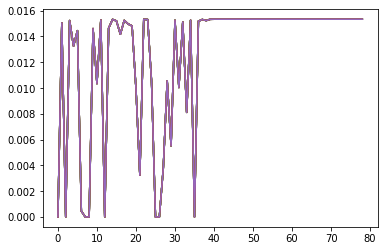

In [797]:
plt.plot(check_rc.T)

In [798]:
check_rc.shape

(15, 79)

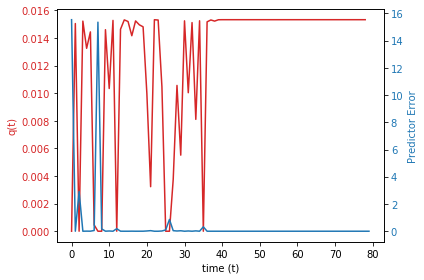

In [806]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (t)')
ax1.set_ylabel('q(t)', color=color)
ax1.plot(check_rc.mean(axis=0), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predictor Error', color=color)  # we already handled the x-label with ax1
ax2.plot(se((new_online_predictions*regime_change).sum(axis=0),regime_new_actual_values), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [800]:
optimal_rc = np.zeros(79)

In [801]:
optimal_rc[78]=1

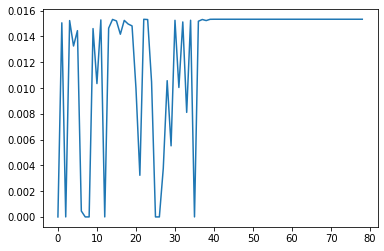

In [802]:
plt.plot(check_rc[6])

In [803]:
check_rc.mean(axis=0)[40:].sum()

0.5979728420667556

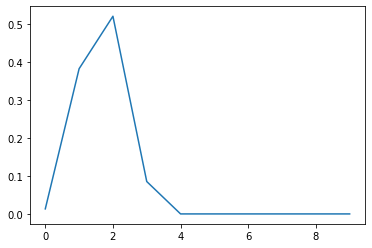

In [804]:
plt.plot(np.dot(new_online_predictions[:,:-1],check_rc[6]))

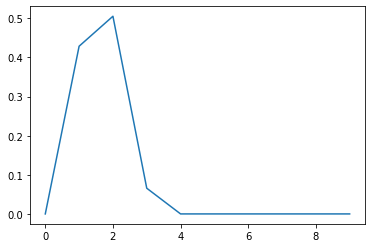

In [432]:
plt.plot(np.dot(new_online_predictions[:,:-1],check_rc.T).mean(axis=1))

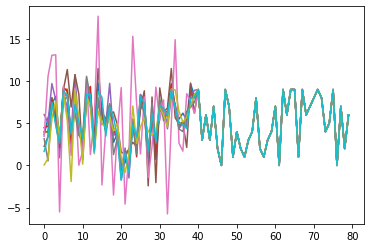

In [433]:
plt.plot(regime_change.T)